## Final Project - Group 10

**Group members: Yvaine Xu yx2571, Claire Huang yh4574, Cici Liu zl4444**

**Data Source** https://www.kaggle.com/datasets/prena0808/craigslist-cars-and-trucks-data

**Objectives**

* Explore the factors that most significantly impact used car pricing in the Dallas region
* Build regression models to predict car prices
* Evaluate the model's performance and interpret key drivers of price variation
* Provide insights that can guide pricing strategies for sellers or filtering options for buyers

### Data Fetching + Exploration

In [6]:
import pandas as pd

df = pd.read_excel("used_car_listing.xlsx") 
df.head()

,location,condition,Listed_date,Listed_time,drive,fuel,lat,long,odometer,paint color,...,size,title status,transmission,type,year make model,cylinders,year,make,re_model,MODELS
0,dallas,excellent,2022-06-01,18;17,4wd,gas,32.856174,-96.672722,200396.0,NaN,...,NaN,clean,automatic,SUV,2010 Nissan Xterra,6,2010,Nissan,Nissan Xterra,Xterra
1,dallas,excellent,2022-06-01,18;16,fwd,hybrid,32.856174,-96.672722,152434.0,NaN,...,NaN,clean,automatic,SUV,2007 Lexus RX 400h,6,2007,Lexus,Lexus RX 400h,RX 400h
2,dallas,excellent,2022-06-01,18;16,fwd,gas,32.778500,-97.083400,90000.0,blue,...,mid-size,clean,automatic,sedan,2015 hyundai elantra,4,2015,hyundai,hyundai elantra,elantra
3,dallas,NaN,2022-06-01,18;16,fwd,gas,33.681077,-112.058490,61482.0,NaN,...,NaN,clean,automatic,van,2007 Honda Odyssey EX Power Side-Ent,6,2007,Honda,Honda Odyssey EX Power Side-Ent,Odyssey EX Power Side-Ent
4,dallas,excellent,2022-06-01,18;16,rwd,gas,32.856174,-96.672722,70523.0,NaN,...,mid-size,clean,automatic,sedan,2005 Infiniti G35 Sedan,6,2005,Infiniti,Infiniti G35 Sedan,G35 Sedan


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   location         2604 non-null   object        
 1   condition        1635 non-null   object        
 2   Listed_date      2604 non-null   datetime64[ns]
 3   Listed_time      2604 non-null   object        
 4   drive            1876 non-null   object        
 5   fuel             2603 non-null   object        
 6   lat              2583 non-null   float64       
 7   long             2583 non-null   float64       
 8   odometer         2596 non-null   float64       
 9   paint color      1872 non-null   object        
 10  price            2601 non-null   float64       
 11  size             995 non-null    object        
 12  title status     2604 non-null   object        
 13  transmission     2602 non-null   object        
 14  type             2056 non-null   object 

Then we take a look on missing values in the dataset.

In [8]:
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
location              0
condition           969
Listed_date           0
Listed_time           0
drive               728
fuel                  1
lat                  21
long                 21
odometer              8
paint color         732
price                 3
size               1609
title status          0
transmission          2
type                548
year make model       0
cylinders          1020
year                  0
make                  2
re_model              0
MODELS               30
dtype: int64


### Preprocessing

**Data Preprocessing Summary**

- **Dropped rows with missing values** in core columns required for modeling, including:
  - `'price'`, `'odometer'`, `'year'`, `'condition'`, `'drive'`, `'fuel'`, `'transmission'`, `'paint color'`
- **Removed unhelpful or sparse columns** like `'size'`, `'cylinders'`, and `'type'`
- **Excluded rows missing geographic coordinates** (`lat` and `long`) to ensure completeness
- **Filtered out outliers**:
  - Kept only cars with `odometer < 1,000,000` miles
  - Kept only cars newer than year `1990`
  - Removed the top 1% most expensive listings to reduce the effect of price outliers on prediction accuracy
- **Checked for remaining missing values** and printed the final dataset shape

In [10]:
core_columns = ['price', 'odometer', 'year', 'condition', 'drive', 'fuel', 'transmission', 'paint color']
df_cleaned = df.dropna(subset=core_columns)

columns_to_drop = ['size', 'cylinders', 'type']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

df_cleaned = df_cleaned.dropna(subset=['lat', 'long'])

df_cleaned = df_cleaned[df_cleaned['odometer'] < 1000000]
df_cleaned = df_cleaned[df_cleaned['year'] > 1990]
price_cap = df_cleaned['price'].quantile(0.99)
df_cleaned = df_cleaned[df_cleaned['price'] <= price_cap]

print("Final cleaned dataset shape:", df_cleaned.shape)
print("Missing values after cleaning:")
print(df_cleaned.isnull().sum())

Final cleaned dataset shape: (987, 18)
Missing values after cleaning:
location           0
condition          0
Listed_date        0
Listed_time        0
drive              0
fuel               0
lat                0
long               0
odometer           0
paint color        0
price              0
title status       0
transmission       0
year make model    0
year               0
make               2
re_model           0
MODELS             6
dtype: int64


### Exploratory Data Analysis

Text(0.5, 1.0, 'Used Car Price Distribution')

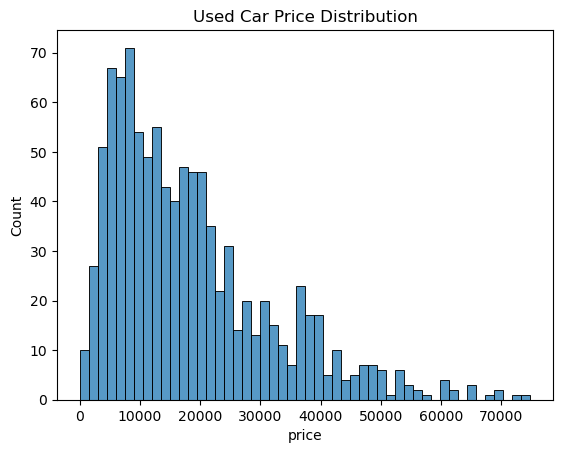

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_cleaned['price'], bins=50)
plt.title("Used Car Price Distribution")

- The majority of listings are priced between `$5,000` and `$20,000`, indicating a concentration of lower- to mid-priced vehicles.
- The distribution is right-skewed, with a long tail extending toward higher price points, up to $75,000.
- This skewness suggests the presence of a few high-end or luxury vehicles, which are much less common but can significantly affect model performance if not handled (e.g., by capping or transforming prices).

#### Price Distribution of Major Brands

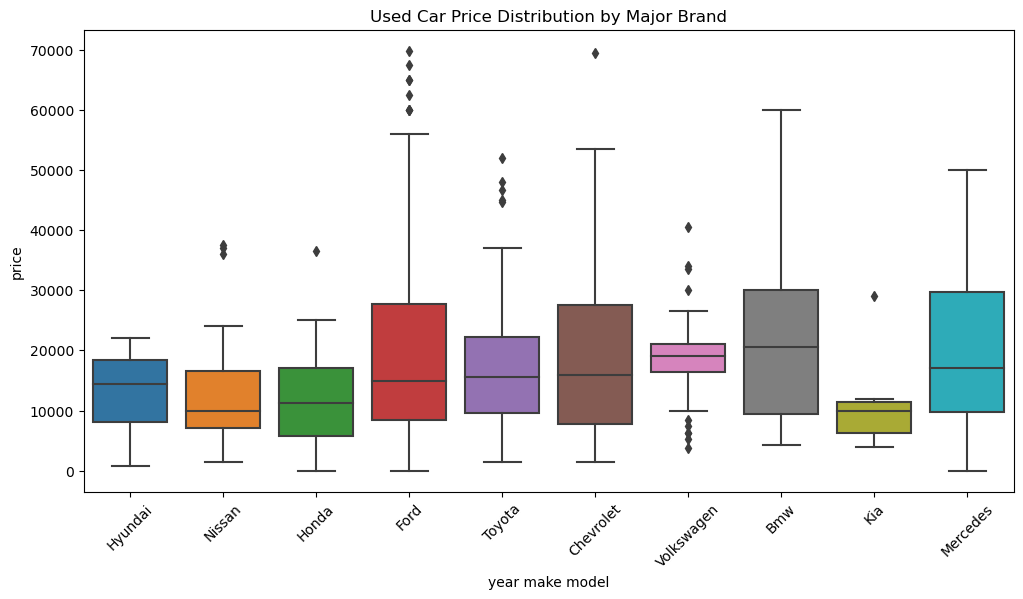

In [14]:
main_brands = ['toyota', 'honda', 'ford', 'chevrolet', 'bmw', 'nissan', 'hyundai', 'kia', 'mercedes', 'volkswagen']

brand_series = df_cleaned['year make model'].apply(
    lambda x: next((b.title() for b in main_brands if isinstance(x, str) and b in x.lower()), 'Other')
)

filtered_index = brand_series != 'Other'

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x=brand_series[filtered_index], y=df_cleaned.loc[filtered_index, 'price'])
plt.title("Used Car Price Distribution by Major Brand")
plt.xticks(rotation=45)
plt.show()

- This boxplot compares the price distributions of used cars across 10 major car brands
- Brands were extracted from the `year make model` column using string matching, and cars not belonging to the top 10 brands were excluded.
- **Insights:**
  - Luxury brands like Mercedes and BMW tend to have higher median prices and wider price ranges.
  - Budget brands like Kia, Hyundai, and Nissan show lower median prices and tighter distributions.
  - Outliers (e.g., extremely high-end models) are visible for brands like Ford, Chevrolet, and Volkswagen.

#### Year in Relation to Price

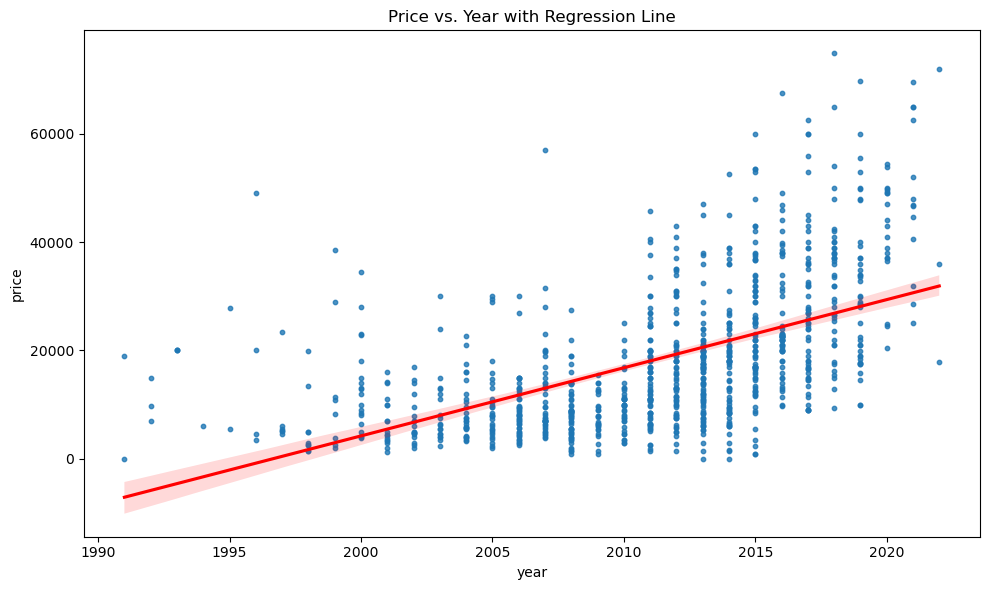

Regression equation: price = 1258.03 * year + -2511824.58


In [16]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df_cleaned, x='year', y='price', scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title("Price vs. Year with Regression Line")
plt.tight_layout()
plt.show()

from sklearn.linear_model import LinearRegression
import numpy as np

X = df_cleaned[['year']].values
y = df_cleaned['price'].values

model = LinearRegression()
model.fit(X, y)

slope = model.coef_[0]
intercept = model.intercept_

print(f"Regression equation: price = {slope:.2f} * year + {intercept:.2f}")

- This scatterplot shows the relationship between a vehicle's manufacturing year and its listed price.

- **Interpretation**:
  - The **positive slope** of ~1258 suggests that, on average, each additional year increases the car’s expected price by about **$1,258**.
  - This confirms a **strong positive correlation**: newer cars generally command higher prices.
- The plot also shows significant vertical spread (especially in recent years), which reflects that factors beyond year (e.g., brand, mileage, condition) also impact price and should be included in multivariate models.

#### Pearson Correlation Coefficient

In [95]:
from scipy.stats import pearsonr

year = df_cleaned['year']
price = df_cleaned['price']

corr, p_value = pearsonr(year, price)

print(f"Pearson correlation coefficient: {corr:.2f}")
print(f"P-value: {p_value:.4f}")

Pearson correlation coefficient: 0.55
P-value: 0.0000


- The Pearson correlation coefficient between year and price is approximately 0.55, with a p-value effectively 0 (2.87e-78), indicating a moderate positive linear relationship that is statistically significant.
- Newer cars tend to be more expensive. 

#### Odometer in Relation to Price

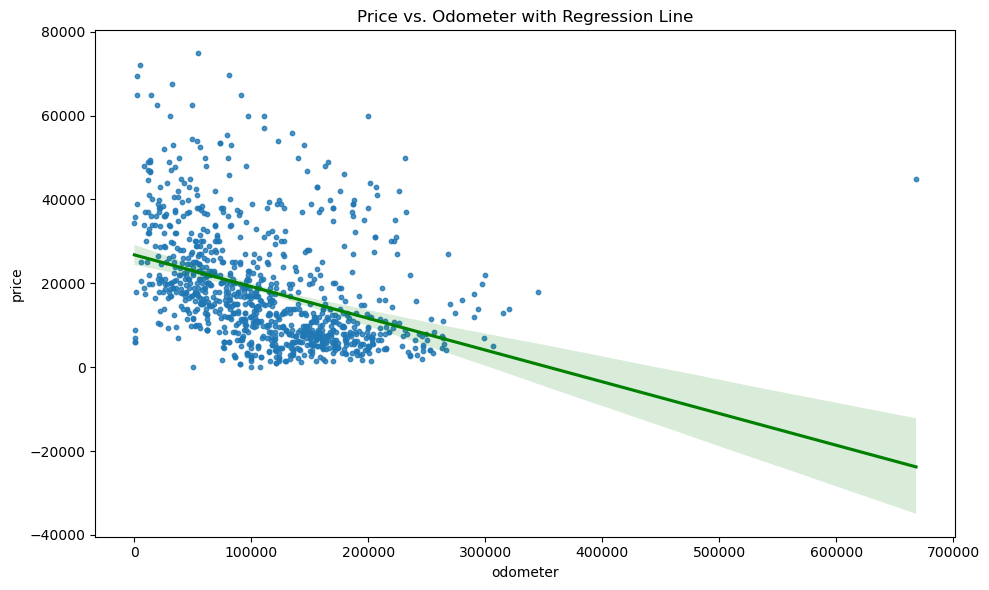

Regression equation: price = -0.08 * odometer + 26795.67


In [18]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df_cleaned, x='odometer', y='price', scatter_kws={'s': 10}, line_kws={'color': 'green'})
plt.title("Price vs. Odometer with Regression Line")
plt.tight_layout()
plt.show()

X_odo = df_cleaned[['odometer']].values
y_price = df_cleaned['price'].values

model_odo = LinearRegression()
model_odo.fit(X_odo, y_price)

slope_odo = model_odo.coef_[0]
intercept_odo = model_odo.intercept_

print(f"Regression equation: price = {slope_odo:.2f} * odometer + {intercept_odo:.2f}")

- The scatter plot shows a clear negative correlation: as the odometer reading increases, the car price tends to decrease.

- The green regression line fitted over the data illustrates the trend, with a slope of **−0.08**.  
  This means that **for every additional mile**, the predicted price **drops by around $0.08**.

- The odometer reading is **inversely related** to price, confirming that mileage is a strong factor in determining the depreciation of used vehicles.  


#### Price Distribution by Drive Type

Text(0.5, 1.0, 'Price Distribution by Drive Type')

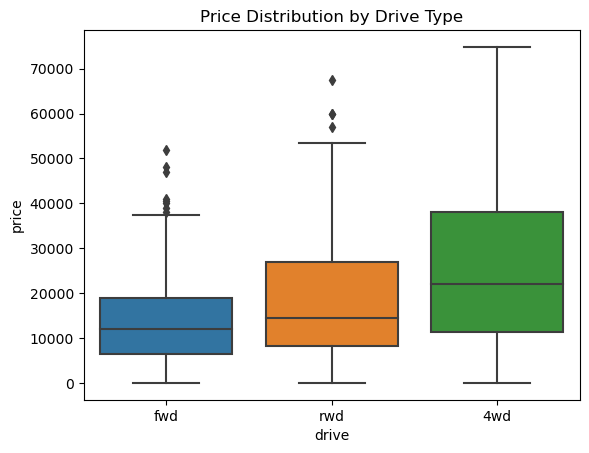

In [20]:
sns.boxplot(data=df_cleaned, x='drive', y='price')
plt.title("Price Distribution by Drive Type")

  This boxplot compares the distribution of used car prices based on different drive types:  
  - `fwd` (Front-Wheel Drive)  
  - `rwd` (Rear-Wheel Drive)  
  - `4wd` (Four-Wheel Drive)

- **4WD vehicles** tend to have the **highest median prices** and wider price ranges, possibly due to their use in trucks/SUVs and off-road capabilities.
- **FWD vehicles** show the **lowest prices** and a tighter distribution, consistent with economical and compact car segments.
- **RWD vehicles** fall in between but exhibit a wider spread and more outliers, which might reflect luxury or performance-oriented models.

In [21]:
drive_price_stats = df_cleaned.groupby('drive')['price'].agg(['mean', 'median', 'std', 'count']).sort_values(by='mean', ascending=False)
drive_price_stats

,mean,median,std,count
drive,,,,
4wd,25543.872587,21995.0,16796.390997,259
rwd,18670.267797,14550.0,12849.965490,295
fwd,13494.986143,11999.0,8711.049746,433


**Insights:**
* 4wd highest average price (common for SUVs/crossovers)
* fwd Lower average price (used for economy cars)

#### Price by Transmission Type

Text(0.5, 1.0, 'Price by Transmission Type')

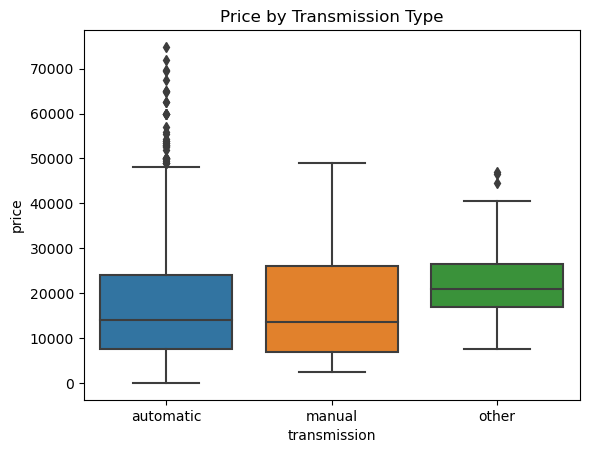

In [24]:
sns.boxplot(data=df_cleaned, x='transmission', y='price')
plt.title("Price by Transmission Type")

In [25]:
transmission_stats = df_cleaned.groupby('transmission')['price'].agg(['mean', 'median', 'std', 'count']).sort_values(by='mean', ascending=False)
transmission_stats

,mean,median,std,count
transmission,,,,
other,23087.721519,20990.0,8684.451025,79
automatic,17801.216568,13990.0,13754.081572,845
manual,17475.603175,13500.0,12783.401892,63


#### Price Distribution by Vehicle Condition

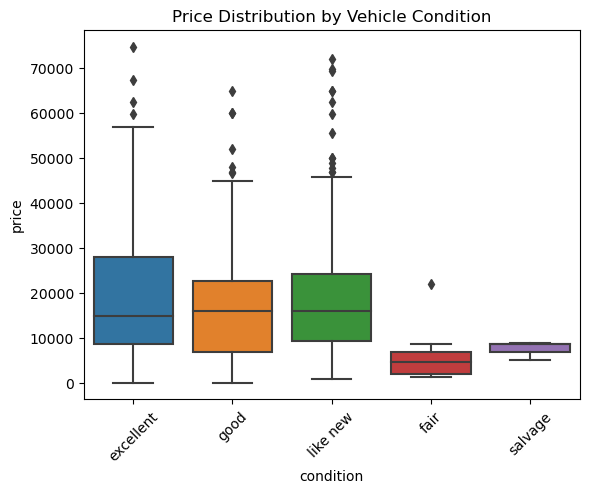

In [27]:
sns.boxplot(data=df_cleaned, x='condition', y='price')
plt.title("Price Distribution by Vehicle Condition")
plt.xticks(rotation=45)
plt.show()

In [28]:
condition_stats = df_cleaned.groupby('condition')['price'].agg(['mean', 'median', 'std', 'count']).sort_values(by='mean', ascending=False)
condition_stats

,mean,median,std,count
condition,,,,
like new,20592.828125,15925.0,16383.308648,128
excellent,19521.153302,14820.0,14162.253595,424
good,16909.110024,16000.0,11277.255405,409
salvage,7416.666667,8500.0,2096.624271,3
fair,5043.217391,4500.0,4379.492851,23


**Insights:**
* like new, excellent, good prices are close, especially since like new is not always the highest because of inconsistent labeling standards
* salvage and fair are significantly underpriced, which is in line with expectations

#### Price Distribution by Fuel Type

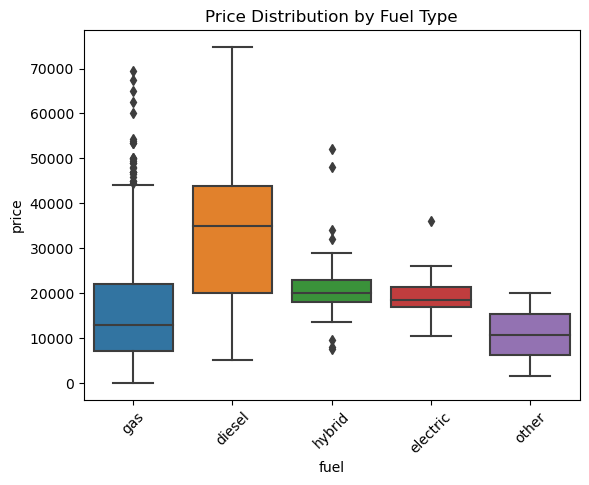

In [31]:
sns.boxplot(data=df_cleaned, x='fuel', y='price')
plt.title("Price Distribution by Fuel Type")
plt.xticks(rotation=45)
plt.show()

In [32]:
fuel_stats = df_cleaned.groupby('fuel')['price'].agg(['mean', 'median', 'std', 'count']).sort_values(by='mean', ascending=False)
fuel_stats

,mean,median,std,count
fuel,,,,
diesel,34284.783019,34995.0,15975.863498,106
hybrid,21550.810811,19990.0,8754.680773,37
electric,19434.375000,18490.0,5990.440127,16
gas,15984.157385,12825.0,11828.798897,826
other,10745.000000,10745.0,13074.404384,2


**Insights:**
* Diesel is significantly more expensive and is often used in commercial vehicles or high-performance SUVs
* Hybrid and Electric have similar but lower average prices than diesel, suggesting that although they are new technologies, many are economy vehicles
* Gas is the dominant fuel, with a wide range of prices
* The Other category of fuel types has the lowest prices and may be a record of miscellaneous items or lack of information

#### Price Distribution by Paint Color

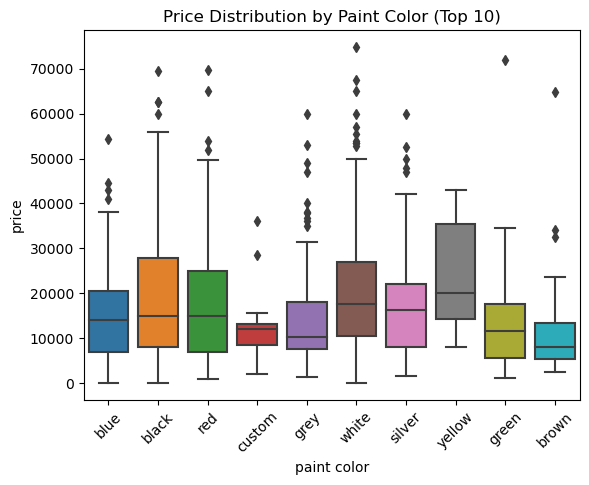

In [35]:
top_colors = df_cleaned['paint color'].value_counts().nlargest(10).index
filtered_df = df_cleaned[df_cleaned['paint color'].isin(top_colors)]

sns.boxplot(data=filtered_df, x='paint color', y='price')
plt.title("Price Distribution by Paint Color (Top 10)")
plt.xticks(rotation=45)
plt.show()

In [90]:
from scipy.stats import f_oneway

top_colors = df_cleaned['paint color'].value_counts().nlargest(10).index
filtered_df = df_cleaned[df_cleaned['paint color'].isin(top_colors)]

grouped_prices = [filtered_df[filtered_df['paint color'] == color]['price'] for color in top_colors]

f_stat, p_value = f_oneway(*grouped_prices)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

ANOVA F-statistic: 3.15, p-value: 0.0009


- **Statistical Finding**: The ANOVA test produced a p-value of 0.0009 (< 0.05), confirming that **paint color significantly affects used car price**.
- **High-Value Colors**: 
  - **Yellow** and **white** exhibit higher median prices with larger variability, indicating association with newer or premium models.
  - **Black** remains a strong performer, commonly perceived as classic and desirable in multiple segments.
- **Lower-Value Colors**:
  - **Green**, **brown**, and **custom** colors tend to cluster at lower price levels, suggesting limited market appeal or older inventory.

**Strategic Recommendations**

- **Inventory Optimization**:
  - Focus purchasing and restocking strategies on vehicles in **white**, **black**, and **yellow**, which are statistically associated with higher resale values.
- **Pricing Strategy**:
  - Offer strategic discounts or value-added bundles (e.g., extended warranty, maintenance packages) for slower-moving colors like **green** or **brown**.
- **Customer Targeting**:
  - Segment marketing campaigns: Use premium colors for high-margin promotions and use lower-price colors to appeal to price-sensitive buyers.
- **Forecasting & Planning**:
  - Incorporate color impact into **price prediction models** and **sales forecasts** to improve accuracy in revenue planning and demand estimation.

In [36]:
features = ['year', 'odometer', 'drive', 'fuel', 'transmission', 'condition', 'paint color']
target = 'price'

import statsmodels.api as sm

ols_df = df_cleaned[features + [target]].dropna()

X = pd.get_dummies(ols_df[features], drop_first=True).astype(float)

X = sm.add_constant(X)

y = ols_df[target]

In [37]:
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     77.07
Date:                Tue, 06 May 2025   Prob (F-statistic):          1.42e-209
Time:                        17:05:26   Log-Likelihood:                -10238.
No. Observations:                 987   AIC:                         2.053e+04
Df Residuals:                     961   BIC:                         2.066e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.939e+06   1

#### Random Forest Regression for Price Prediction

**Data Preprocessing**
* Target variable: 'price'
* We excluded irrelevant or unstructured columns such as `'Listed_date', 'location', and 'year make model'` to avoid noise or redundancy.
* Used `pd.get_dummies()` to convert categorical variables into numerical dummy variables so that machine learning models can use them.

**Data Splitting**
* Split the dataset into training (80%) and testing (20%) using train_test_split().

**Model Training**
* We used a Random Forest Regressor with:
* `n_estimators=100 `(number of decision trees)
* `max_depth=10` (to prevent overfitting)
* Trained the model with `.fit()` and made predictions using `.predict()`.

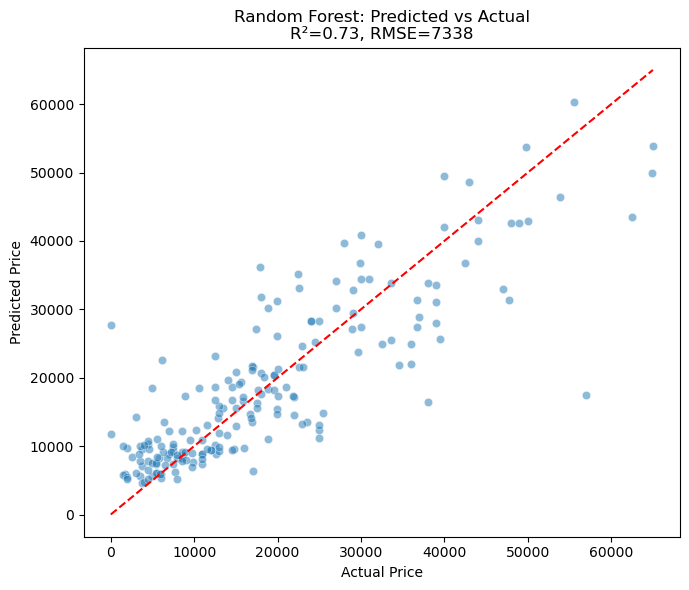

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

target = 'price'
exclude_columns = ['price', 'Listed_date', 'Listed_time', 'location', 'title status', 'year make model', 'make', 're_model', 'MODELS']
X = df_cleaned.drop(columns=exclude_columns, errors='ignore')
y = df_cleaned[target]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

forest_r2 = r2_score(y_test, y_pred_forest)
forest_rmse = mean_squared_error(y_test, y_pred_forest, squared=False)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred_forest, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Random Forest: Predicted vs Actual\nR²={forest_r2:.2f}, RMSE={forest_rmse:.0f}")
plt.tight_layout()
plt.show()

**Model Evaluation**

R² = 0.73: The model explains 73% of the variation in price. That’s a decent performance for a real-world, noisy dataset.

RMSE ≈ 7338: On average, predictions are about $7,338 off from actual prices.

**Explaination**

Although our Random Forest model has a good R² of 0.73, the RMSE value of 7,338 is high. The source of the high error is primarily the outliers, cars that have extremely high prices (over $50,000). These outliers result in a high spread in the expected vs. predicted values that proportionally impact the RMSE due to the fact that larger errors impact it more. Thus, although the model fits most of the observations tightly, the outlier values push the metric for overall error up.

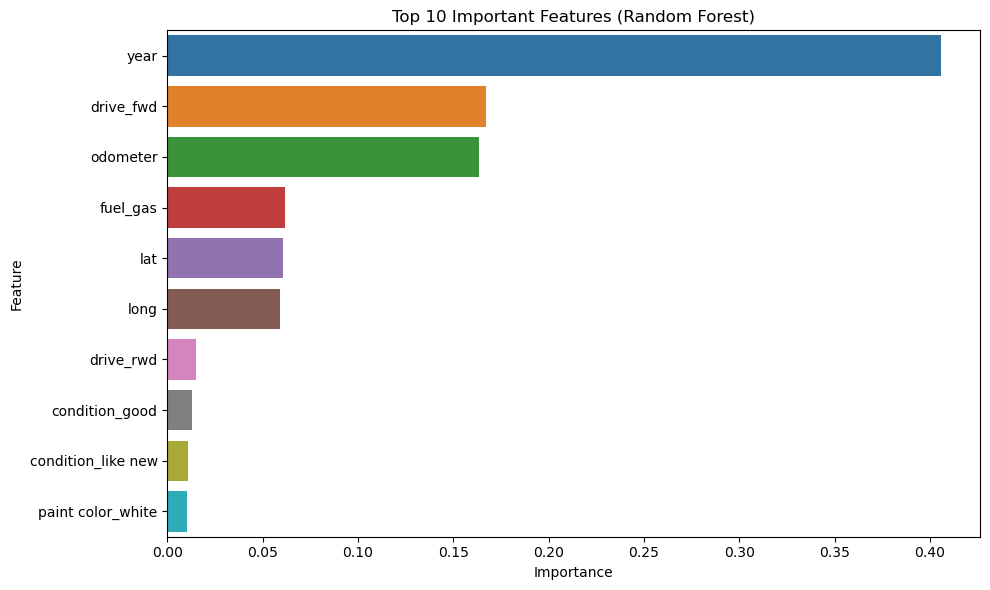

In [43]:
importances = forest.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()